# Initialisation

In [2]:
%config Completer.use_jedi = False
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
import os
os.environ["OMP_NUM_THREADS"] = str(os.cpu_count())
os.environ["OPENBLAS_NUM_THREADS"] = str(os.cpu_count())
os.environ["MKL_NUM_THREADS"] = str(os.cpu_count())
os.environ["VECLIB_MAXIMUM_THREADS"] = str(os.cpu_count())
os.environ["NUMEXPR_NUM_THREADS"] = str(os.cpu_count())

import re
import sys
import dill as dill
import time
import math
import random
import pickle
import imageio
import inspect
import json
import numpy as np
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext.data as ttd
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools #Needed fot Confusion Matrix
import scipy.stats as stat # Since the p-values are obtained through certain statistics, we need the 'stat' module from scipy.stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.cm as cmap #Importing colormap
sns.set()

from pytz import timezone
from datetime import datetime
from sklearn import linear_model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression #Gets the p-values of the coefficients
from sklearn.cluster import KMeans
from torchsummary import summary
from torchtext.vocab import GloVe
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from glob import glob
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from torchvision import datasets, transforms, models
from skimage.io import imread
from winsound import Beep
from scipy.special import softmax


print("PyTorch v" + torch.__version__)
IS_GPU_AVAILABLE = torch.cuda.is_available()
print(f"CUDA device available: {IS_GPU_AVAILABLE}")
if (torch.cuda.is_available()):
    print(str(torch.cuda.device_count()) + " devices available")
    for n in range(torch.cuda.device_count()):
        print("\t" + torch.cuda.get_device_name(n))
    print("cuda:", torch.cuda.current_device()) #It can give you information like the GPU is not supported
print("Num threads set to:", os.cpu_count())
torch.set_num_threads(os.cpu_count())

def SaveVariable(Variable, FileName):
    with open(FileName, 'wb') as io:
        pickle.dump(Variable, io)
    
def LoadVariable(FileName):
    with open(FileName, "rb") as io:
        Res = pickle.load(io)
    return Res

def RemLastLine(s):
    return s[:s.rfind('\n')]

def init_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalisation can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalisation')

    print(cm)

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("device=", device)

PyTorch v1.8.1+cu111
CUDA device available: True
1 devices available
	NVIDIA GeForce RTX 2080 SUPER
cuda: 0
Num threads set to: 48
device= cuda


# Data

In [4]:
class NxD_to_NxTxD2_From_D_Dataset(Dataset): #Here, the previous steps are not previous observations (on N), but are within the D dimension on an NxD Matrix
    def __init__(self, data, targets, T):
        self.data = data
        self.targets = targets
        self.shape = (data.shape[0], T, data.shape[1] - T)
        self.T = T

    def __getitem__(self, index):
        NewX = []
        for t in range(self.data.shape[1] - self.T):
            x = self.data[index, t : t + self.T]
            NewX.append(x)
        
        NewX = np.array(NewX).reshape(-1, self.shape[1], self.shape[2])
        NewX = np.transpose(NewX, (1, 2, 0))
        Targets = self.targets[index]

        return NewX, Targets

    def __len__(self):
        return len(self.data)
    
    def __shape__(self):
        return self.shape

In [5]:
SupervisedType = "Classification"
UsingPretrainedModel = False
CustomNAString = None
nEmbeddings = None
CustomNAString = None
RandomState = 1337
T = 10500

#################
### One File ###
X, Y = LoadVariable(f"{os.getcwd()}/raw_data.pkl")
#################


XY = pd.DataFrame(X)
XY["Label"] = Y
XY["Label"] = XY["Label"].astype('category').cat.codes
Y = XY["Label"].values

N = X.shape[0]

init_seeds(1337)
TrainPerc = 0.7
TrainIndx, TestIndx = train_test_split(np.arange(X.shape[0]), test_size = 1 - TrainPerc, shuffle = True, stratify = Y, random_state = RandomState)
X_Train = X[TrainIndx]
Y_Train = Y[TrainIndx]
X_Test = X[TestIndx]
Y_Test = Y[TestIndx]

YUnique = set(Y)
Y_TrainUnique = set(Y_Train)
Y_TestUnique = set(Y_Test)
print(f"Unique Values: Y ({len(YUnique)}), Y_Train ({len(Y_TrainUnique)}), Y_Test ({len(Y_TestUnique)}), all values are the same: {YUnique == Y_TrainUnique == Y_TestUnique}")


# print("\n      X:", type(X), X.shape, X.min(), X.max())
# print("X_Train:", type(X_Train), X_Train.shape, X_Train.min(), X_Train.max())
# print("X_Test :", type(X_Test), X_Test.shape, X_Test.min(), X_Test.max())

# print("\nY:      ", type(Y), Y.shape, min(Y), max(Y), len(set(Y)))
# print("Y_Train:", type(Y_Train), Y_Train.shape, min(Y_Train), max(Y_Train), len(set(Y_Train)))
# print("Y_Test: ", type(Y_Test), Y_Test.shape, min(Y_Test), max(Y_Test), len(set(Y_Test)))
# return

batch_size = 256

# train_dataset = NxD_to_NxTxD2_From_D_Dataset(X_Train, Y_Train, T)
# train_loader = torch.utils.data.DataLoader(
#     dataset = train_dataset, 
#     batch_size = batch_size, 
#     shuffle = True
# )

# test_dataset = NxD_to_NxTxD2_From_D_Dataset(X_Test, Y_Test, T)
# test_loader = torch.utils.data.DataLoader(
#     dataset = test_dataset, 
#     batch_size = batch_size, 
#     shuffle = True
# )

print("\nY_Test[:10]:", Y_Test[:10])

# number of classes
K = len(set(Y)) if SupervisedType.lower() == "classification" and len(set(Y)) != 2 else (Y.shape[1] if SupervisedType.lower() == "multivariateregression" else 1) #An output_size (K) > 1 can be either Multiclass or Multivariate-Regression, like Lat/Lon coordinates

if 'train_dataset' in locals() or 'train_dataset' in globals():
    tmpX, tmpY = next(iter(train_loader))
    NonSingularDims = np.sum([1 for DimVal in tmpX.shape if DimVal > 1])
    if NonSingularDims == 2:
        N, D = [DimVal for DimVal in tmpX.shape if DimVal > 1]
        H1, W1 = (0, 0)
    elif NonSingularDims == 3:
        D = 0
        N, H1, W1 =[DimVal for DimVal in tmpX.shape if DimVal > 1] #This is RNN NxTxD
    elif NonSingularDims == 4:
        N, H1, W1, D = [DimVal for DimVal in tmpX.shape if DimVal > 1]
    
else:
    if len(X_Train.shape) == 2:
        N, D = X_Train.shape
        H1, W1 = (0, 0)
    elif len(X_Train.shape) == 3:
        D = 0
        N, H1, W1 = X_Train.shape #This is a Picture with no Colour, not RNN
    elif len(X_Train.shape) == 4:
        N, H1, W1, D = X_Train.shape

print()
print("X.shape      ", X.shape, "Y.shape      ", Y.shape)
print("X_Train.shape", X_Train.shape, " Y_Train.shape", Y_Train.shape)
print("X_Test.shape ", X_Test.shape, " Y_Test.shape ", Y_Test.shape)
print("K         ", K)
print("N:", N, "H1:", H1, "W1:", W1, "D:", D)
if 'train_dataset' in locals() or 'train_dataset' in globals():
    print(f"\nData after transformation with batch size = {batch_size}:")
    print("X.shape", tuple(tmpX.shape), "\tY.shape", tuple(tmpY.shape))

Unique Values: Y (600), Y_Train (600), Y_Test (600), all values are the same: True

Y_Test[:10]: [362 557  25  25 145 386 587 541 108 475]

X.shape       (9600, 11025) Y.shape       (9600,)
X_Train.shape (6719, 11025)  Y_Train.shape (6719,)
X_Test.shape  (2881, 11025)  Y_Test.shape  (2881,)
K          600
N: 6719 H1: 0 W1: 0 D: 11025


# Model

## Architecture

In [5]:
#Static
class Net(nn.Module):
    def __init__(self, K, nEmbeddings):
        super(Net, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(in_features=11025, out_features=6000, bias=False),
            nn.ReLU6(),
            nn.BatchNorm1d(6000, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True),
            nn.Linear(in_features=6000, out_features=6000, bias=False),
            nn.ReLU6(),
            nn.BatchNorm1d(6000, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True),
            nn.Linear(in_features=6000, out_features=6000, bias=False),
            nn.ReLU6(),
            nn.BatchNorm1d(6000, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True),
            nn.Linear(in_features=6000, out_features=6000, bias=False),
            nn.ReLU6(),
            nn.BatchNorm1d(6000, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True),
            nn.Linear(in_features=6000, out_features=600, bias=True)
        )
        
    def forward(self, X):
        out = self.layers(X)
        return out
print("Done")

Done


## Hyper Parameters

In [7]:
if 'train_dataset' in locals() or 'train_dataset' in globals():
    conv_input_size = tuple([DimVal for DimVal in tmpX[0].shape if DimVal > 1])
else:
    conv_input_size = X[0].shape #Also used in RNNs
input_size = np.prod(conv_input_size) #np.prod(conv_input_size) #X_Train.shape[1] - len(ColumnsToBeDropped)
output_size = K
doFlatten = False #To NOT use conv, and flatten the image to begin with
if doFlatten:
    D = input_size
print("conv_input_size: " + str(conv_input_size) + ", input_size: " + str(input_size) + ", D: " + str(D) + ", output_size: " + str(output_size))
print("doFlatten=", doFlatten)

if (UsingPretrainedModel):
    hn1 = D_after_pretrain
elif H1 > 1 and W1 > 1 and D == 0:
    hn1 = W1 #1 #It's a photo with no Colour layers and we Conv with it, not RNN which can't handle 4D tensors
else:
    hn1 = D if D > 0 else W1
    
EmbDim = None

# layer_type = ["dense", "dense", "dense", "dense"] #"dense", "rnn", "gru", "lstm", "conv", "stridedconv", "convpool"
num_layers = [1] #[1] #Only used for RNNs so far
l2_lamda = 0.2
mu = 0.9 #Momentum
print()

GDType = "minibatch"

conv_input_size: (11025,), input_size: 11025, D: 11025, output_size: 600
doFlatten= False



## Optimisation

### Structure

In [8]:
train_losses = np.array([])
test_losses = np.array([])

In [9]:
model = Net(K, nEmbeddings = nEmbeddings).to(device)
if (UsingPretrainedModel):
    PretrainedModel.classifier = model.to(device)
    model = PretrainedModel.to(device)
print(device)
print(model)

train_losses = np.array([])
test_losses = np.array([])

cuda
Net(
  (layers): ModuleList(
    (0): Linear(in_features=11025, out_features=6000, bias=False)
    (1): ReLU6()
    (2): BatchNorm1d(6000, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
    (3): Linear(in_features=6000, out_features=6000, bias=False)
    (4): ReLU6()
    (5): BatchNorm1d(6000, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
    (6): Linear(in_features=6000, out_features=6000, bias=False)
    (7): ReLU6()
    (8): BatchNorm1d(6000, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
    (9): Linear(in_features=6000, out_features=6000, bias=False)
    (10): ReLU6()
    (11): BatchNorm1d(6000, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
    (12): Linear(in_features=6000, out_features=600, bias=True)
  )
)


In [10]:
Debug = False
print("conv_input_size:", conv_input_size, "\n")
if not "lstm" in layer_type and SupervisedType != "Recommender": #LSTM don't work with summary #"'tuple' object has no attribute 'size'" error in torchsummary.py line 23
    if ((any(item in ["conv", "stridedconv", "convpool"] for item in layer_type) or UsingPretrainedModel) and conv_input_size[0] == H1):
        summary(model, tuple(conv_input_size[i] for i in [2, 0, 1]), device = str(device))
    else:
        summary(model, conv_input_size, device = str(device))

conv_input_size: (11025,) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 6000]      66,150,000
             ReLU6-2                 [-1, 6000]               0
       BatchNorm1d-3                 [-1, 6000]          12,000
            Linear-4                 [-1, 6000]      36,000,000
             ReLU6-5                 [-1, 6000]               0
       BatchNorm1d-6                 [-1, 6000]          12,000
            Linear-7                 [-1, 6000]      36,000,000
             ReLU6-8                 [-1, 6000]               0
       BatchNorm1d-9                 [-1, 6000]          12,000
           Linear-10                 [-1, 6000]      36,000,000
            ReLU6-11                 [-1, 6000]               0
      BatchNorm1d-12                 [-1, 6000]          12,000
           Linear-13                  [-1, 600]       3,600,600
Total param

In [18]:
if (SupervisedType.lower() != "gan"):
    if (SupervisedType.lower() == "regression" or SupervisedType.lower() == "multivariateregression") or SupervisedType.lower() == "recommender":
        criterion = nn.MSELoss()
        if SupervisedType.lower() == "recommender":
            print("Recommender / MSELoss")
        elif SupervisedType.lower() == "multivariateregression":
            print("Regression (Multivariate)")
        else:
            print("Regression")
    elif (SupervisedType.lower() == "classification"):
        if (K == 1):
            criterion = nn.BCEWithLogitsLoss()
            print("Binary Classification")
        else:
            criterion = nn.CrossEntropyLoss()
            print("Multiclass Classification")

    learning_rate = 1e-4

    #optimiser = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = mu, nesterov = False, weight_decay = l2_lamda) #LR=0.01
    #Adam is fast, but tends to overfit
    optimiser = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = (mu, 0.999), weight_decay = l2_lamda) #LR=0.001 (0.9, 0.999)

Multiclass Classification


## Stochastic Gradient Descent (NumPy Array)

In [12]:
def minibatch_gd(model, criterion, optimiser, X_Train, Y_Train, X_Test, Y_Test, epochs, batch_size, ShufflePerIteration):
    start_time = time.time()
    model.to(device)
    
    if (H1 > 0 and W1 > 0 and D > 0):
        X_Train = np.transpose(X_Train, (0, 3, 1, 2))
        X_Test = np.transpose(X_Test, (0, 3, 1, 2))
    
    if (SupervisedType.lower() == "recommender"): #On Recommender, X_Train/X_Test are tuples, not NumPy Arrays
        X_Train = list(X_Train)
        X_Test = list(X_Test)
        for i in range(len(X_Train)):
            X_Train[i] = torch.from_numpy(X_Train[i]).long()
            X_Test[i] = torch.from_numpy(X_Test[i]).long()
    else:
        X_Train = torch.from_numpy(X_Train).float()
        X_Test = torch.from_numpy(X_Test).float()
        
    if (SupervisedType.lower() == "recommender" or SupervisedType.lower() == "regression" or SupervisedType.lower() == "multivariateregression") or (SupervisedType.lower() == "classification" and K == 1):
        Y_Train = torch.from_numpy(Y_Train).float()
        Y_Test = torch.from_numpy(Y_Test).float()
    elif (SupervisedType.lower() == "classification"):
        Y_Train = torch.from_numpy(Y_Train).long()
        Y_Test = torch.from_numpy(Y_Test).long()
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    batches_per_epoch = int(np.ceil(Y_Train.shape[0] / batch_size))
    print("batches:", batch_size, "batches_per_epoch:", batches_per_epoch)
    
    for it in range(epochs):
        t0 = datetime.now()
        
        if (ShufflePerIteration):
            RandIndx = np.arange(Y_Train.shape[0])
            np.random.shuffle(RandIndx) #inplace function

            if (SupervisedType.lower() == "recommender"):
                X_Train = list(X_Train)
                for i in range(len(X_Train)):
                    X_Train[i] = X_Train[i][RandIndx]
                X_Train = tuple(X_Train)
            else:
                X_Train = X_Train[RandIndx]
            Y_Train = Y_Train[RandIndx]
        elif (not ShufflePerIteration and SupervisedType.lower() == "recommender"):
            X_Train = tuple(X_Train)
        
        model.train()
        train_loss = []
        for j in range(batches_per_epoch):
            if SupervisedType.lower() == "recommender":
                inputs = list()
                for i in range(len(X_Train)):
                    inputs.append(X_Train[i][j*batch_size:(j+1)*batch_size])
                inputs = tuple(inputs)
            else:
                inputs = X_Train[j*batch_size:(j+1)*batch_size]
            targets = Y_Train[j*batch_size:(j+1)*batch_size]
            
            if not SupervisedType.lower() == "recommender":
                inputs = inputs.to(device) #Move data to GPU if GPU exists
            targets = targets.to(device) #Move data to GPU if GPU exists
            
            optimiser.zero_grad() #Initialisation for parameters is another method here?
            outputs = model(inputs)

            if K == 1:
                outputs = outputs.view(-1)
            #print(outputs.dtype, Y_Train.dtype)
            loss = criterion(outputs, targets)
            loss.backward()
            train_loss.append(loss.item())
            
            optimiser.step()
        train_loss = np.mean(train_loss)

        model.eval()
        test_loss = []
        for j in range(int(np.ceil(Y_Test.shape[0] / batch_size))):
            if SupervisedType.lower() == "recommender":
                test_inputs = list()
                for i in range(len(X_Test)):
                    test_inputs.append(X_Test[i][j*batch_size:(j+1)*batch_size])
                test_inputs = tuple(test_inputs)
            else:
                test_inputs = X_Test[j*batch_size:(j+1)*batch_size]
            test_targets = Y_Test[j*batch_size:(j+1)*batch_size]
            
            if not SupervisedType.lower() == "recommender":
                test_inputs = test_inputs.to(device) #Move data to GPU if GPU exists
            test_targets = test_targets.to(device) #Move data to GPU if GPU exists
            
            test_outputs = model(test_inputs)
            
            if K == 1:
                test_outputs = test_outputs.view(-1)
            
            test_loss = criterion(test_outputs, test_targets).item()
        test_loss = np.mean(test_loss)
        
        #Save the loss
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        if (it + 1) % 1 == 0:
            dt = datetime.now() - t0
            print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')
    
    elapsed_time = time.time() - start_time
    FinishedOn = datetime.now(timezone('Europe/Athens')).strftime("%a, %Y-%m-%d %H:%M %Z %z")
    print("\n\nDone (" + FinishedOn + ") Elapsed time: " + str(round(elapsed_time, 1)) + " seconds")
    return train_losses, test_losses

GDType = "minibatch"
Debug = False
new_train_losses, new_test_losses = minibatch_gd(model, criterion, optimiser, X_Train, Y_Train, X_Test, Y_Test, epochs = 50, batch_size = batch_size, ShufflePerIteration = True)
train_losses = np.append(train_losses, new_train_losses)
test_losses = np.append(test_losses, new_test_losses)
train_loss = train_losses[-1]
test_loss = test_losses[-1]

batches: 256 batches_per_epoch: 27
Epoch 1/50, Train Loss: 6.5336, Test Loss: 6.5652, Duration: 0:00:02.688969
Epoch 2/50, Train Loss: 6.0872, Test Loss: 6.5115, Duration: 0:00:02.571449
Epoch 3/50, Train Loss: 5.7630, Test Loss: 6.4840, Duration: 0:00:02.573449
Epoch 4/50, Train Loss: 5.4873, Test Loss: 6.4081, Duration: 0:00:02.581451
Epoch 5/50, Train Loss: 5.2507, Test Loss: 6.4367, Duration: 0:00:02.602457
Epoch 6/50, Train Loss: 5.0590, Test Loss: 6.4254, Duration: 0:00:02.604956
Epoch 7/50, Train Loss: 4.8995, Test Loss: 6.4641, Duration: 0:00:02.604954
Epoch 8/50, Train Loss: 4.7721, Test Loss: 6.4340, Duration: 0:00:02.588452
Epoch 9/50, Train Loss: 4.6640, Test Loss: 6.4078, Duration: 0:00:02.618457
Epoch 10/50, Train Loss: 4.5784, Test Loss: 6.4246, Duration: 0:00:02.616457
Epoch 11/50, Train Loss: 4.5131, Test Loss: 6.4039, Duration: 0:00:02.674967
Epoch 12/50, Train Loss: 4.4582, Test Loss: 6.4083, Duration: 0:00:02.768483
Epoch 13/50, Train Loss: 4.4204, Test Loss: 6.4062

## Stochastic Gradient Descent (Dataset)

In [ ]:
def batch_gd(model, criterion, optimiser, train_loader, test_loader, epochs):
    start_time = time.time()
    model.to(device)
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []
        
        model.train()
        for inputs, targets in train_loader:
            if (D == 0 and H1 > 0 and W1 > 0):
                inputs = inputs.view(-1, H1, W1) #Probably an image of shape NxH1xW1x1, so let's delete the useless dimension
            if (EmbDim is None):
                inputs = inputs.float()
            if (SupervisedType.lower() == "recommender" or SupervisedType.lower() == "regression" or SupervisedType.lower() == "multivariateregression") or (SupervisedType.lower() == "classification" and K == 1):
                targets = targets.float()
            elif (SupervisedType.lower() == "classification"):
                targets = targets.long()
                
            if not SupervisedType.lower() == "recommender":
                inputs = inputs.to(device) #Move data to GPU if GPU exists
            targets = targets.to(device) #Move data to GPU if GPU exists
            
            optimiser.zero_grad() #Initialisation for parameters is another method here?

#             print("inputs.shape:", inputs.shape)
            outputs = model(inputs)
            if K == 1:
                outputs = outputs.view(-1)
            
#             print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
#             print("Unique targets:", len(torch.unique(targets)), "\n\n", torch.unique(targets))
            loss = criterion(outputs, targets)
            loss.backward()
            train_loss.append(loss.item())
            
            optimiser.step()
            print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}')
        train_loss = np.mean(train_loss) #Alternatively we could add all Iteration Losses instead of 1 Epoch loss, but the array length will be higher than Validation's
        
        test_loss = []
        model.eval()
        for inputs, targets in test_loader:
            if (D == 0 and H1 > 0 and W1 > 0):
                inputs = inputs.view(-1, H1, W1) #Probably an image of shape NxH1xW1x1, so let's delete the useless dimension
            if (EmbDim is None):
                inputs = inputs.float()
            if (SupervisedType.lower() == "regression" or SupervisedType.lower() == "multivariateregression") or (SupervisedType.lower() == "classification" and K == 1):
                targets = targets.float()
            elif (SupervisedType.lower() == "classification"):
                targets = targets.long()
                
            if not SupervisedType.lower() == "recommender":
                inputs = inputs.to(device) #Move data to GPU if GPU exists
            targets = targets.to(device) #Move data to GPU if GPU exists
            
            outputs = model(inputs)
            if K == 1:
                outputs = outputs.view(-1)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)
        
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')
    
    elapsed_time = time.time() - start_time
    FinishedOn = datetime.now(timezone('Europe/Athens')).strftime("%a, %Y-%m-%d %H:%M %Z %z")
    print("Done (" + FinishedOn + ") Elapsed time: " + str(round(elapsed_time, 1)) + " seconds")
    return train_losses, test_losses

GDType = "stochastic"
Debug = False
new_train_losses, new_test_losses = batch_gd(model, criterion, optimiser, train_loader, test_loader, epochs = 1)
train_losses = np.append(train_losses, new_train_losses)
test_losses = np.append(test_losses, new_test_losses)
train_loss = train_losses[-1]
test_loss = test_losses[-1]

# Evaluation

## Multiclass

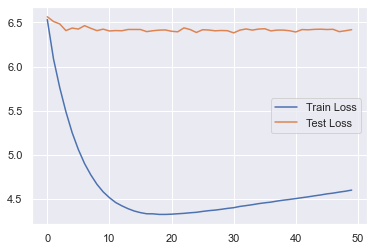

In [13]:
plt.plot(train_losses, label = "Train Loss")
plt.plot(test_losses, label = "Test Loss")
plt.legend()
plt.show()

In [14]:
#Full Gradient Descent
model.eval()
if not "train_losses" in locals() and not "train_losses" in globals():
    train_losses = [-np.Inf]
with torch.no_grad():
    if GDType == "full":
        print("Full Gradient Descent")        
    elif GDType == "stochastic":
        print("Stochastic GD")
        Actual_Y = np.array([])
        Test_Actual_Y = np.array([])
        #Stochastic Gradient Descent #Tested with Flatenned MNIST
        model.to(device)

        n_correct = 0.
        n_total = 0.
        for inputs, targets in train_loader:
            if (D == 0 and H1 > 0 and W1 > 0):
                inputs = inputs.view(-1, H1, W1) #Probably an image of shape NxH1xW1x1, so let's delete the useless dimension
            inputs = inputs.float()
            if (SupervisedType.lower() == "regression" or SupervisedType.lower() == "multivariateregression") or (SupervisedType.lower() == "classification" and K == 1):
                targets = targets.float()
            elif (SupervisedType.lower() == "classification"):
                targets = targets.long()
            inputs, targets = inputs.to(device), targets.to(device) #Move data to GPU if GPU exists

            #inputs = inputs.view(-1, D) #Reshape the input if needed
            #inputs = inputs.view(-1, train_dataset.data.shape[1], train_dataset.data.shape[2]) #Reshape the X_Train batch if needed

            Actual_Y = np.append(Actual_Y, targets.cpu().numpy().astype(np.int32), axis = 0)
            outputs = model(inputs) #Forward pass
            if K == 1:
                outputs = outputs.view(-1)
            elif (SupervisedType.lower() == "classification"): #which means K>1 also
                _, outputs = torch.max(outputs, 1) #Prediction. torch.max returns both max (value) and argmax (index)

            # update counts
            n_correct += (outputs == targets).sum().item() #.item() = One-element tensor -> Python scalar
            n_total += targets.shape[0]
        train_Acc = n_correct / n_total
        
        
        n_correct = 0.
        n_total = 0.
        test_loss = []
        if (SupervisedType.lower() == "classification" and K > 1):
            Pred = np.array([], dtype = np.int64)
            PredProb = []
        else:
            Pred = np.array([])

        for inputs, targets in test_loader:
            if (D == 0 and H1 > 0 and W1 > 0):
                inputs = inputs.view(-1, H1, W1) #Probably an image of shape NxH1xW1x1, so let's delete the useless dimension
            inputs = inputs.float()
            if (SupervisedType.lower() == "regression" or SupervisedType.lower() == "multivariateregression") or (SupervisedType.lower() == "classification" and K == 1):
                targets = targets.float()
            elif (SupervisedType.lower() == "classification"):
                targets = targets.long()
            inputs, targets = inputs.to(device), targets.to(device) #Move data to GPU if GPU exists

            #inputs = inputs.view(-1, test_dataset.data.shape[1], test_dataset.data.shape[2]) #Reshape the X_Train batch if needed
            #inputs = inputs.view(-1, D) #Reshape the input if needed

            Test_Actual_Y = np.append(Test_Actual_Y, targets.cpu().numpy().astype(np.int32), axis = 0)
            outputs = model(inputs) #Forward pass
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())

            if K == 1:
                outputs = outputs.view(-1)
            elif (SupervisedType.lower() == "classification"): #which means K>1 also
                PredProb.extend(outputs.cpu().numpy())
                _, outputs = torch.max(outputs, 1) #Prediction. torch.max returns both max (value) and argmax (index)

            Pred = np.append(Pred, outputs.cpu().numpy())

            # update counts
            n_correct += (outputs == targets).sum().item()
            n_total += targets.shape[0]


        PredProb = np.array(PredProb)
        #################################
        ## Get the Losses to plot them ##
        #################################
        print("Test Iterations:", len(test_loss))
        print("Test ~N:", (len(test_loss) * batch_size))
        print()
        test_loss = np.mean(test_loss)
        test_Acc = n_correct / n_total
        ClassWeightedF1 = f1_score(Test_Actual_Y, Pred, average = 'weighted')
        
        print('Train loss: {0:.3f}. Train Acc: {1:.2f}%.'.format(train_losses[-1], train_Acc * 100.))
        print(' Test loss: {0:.3f}.  Test Acc: {1:.2f}%.  Class Weighted F1 Score: {2:.2f}%'.format(test_loss, test_Acc * 100., ClassWeightedF1 * 100.))
        
    elif GDType == "minibatch":
        print("Minibatch (NumPy)")
        Actual_Y = np.array([])
        Test_Actual_Y = np.array([])
        Batches = int(np.ceil(Y_Train.shape[0] / batch_size))
        
        n_correct = 0.
        n_total = 0.
        for j in range(Batches):
            inputs, targets = torch.from_numpy(X_Train[j*batch_size:(j+1)*batch_size]).float().to(device), torch.from_numpy(Y_Train[j*batch_size:(j+1)*batch_size]).float().to(device) #Move data to GPU if GPU exists
            
            if (H1 > 0 and W1 > 0 and D > 0): ### Not sure if it belongs here ###
                inputs = inputs.permute(0, 3, 1, 2)
                
            if (D == 0 and H1 > 0 and W1 > 0):
                inputs = inputs.view(-1, H1, W1) #Probably an image of shape NxH1xW1x1, so let's delete the useless dimension
            inputs = inputs.float()
            if (SupervisedType.lower() == "regression" or SupervisedType.lower() == "multivariateregression") or (SupervisedType.lower() == "classification" and K == 1):
                targets = targets.float()
            elif (SupervisedType.lower() == "classification"):
                targets = targets.long()
            inputs, targets = inputs.to(device), targets.to(device) #Move data to GPU if GPU exists

            #inputs = inputs.view(-1, D) #Reshape the input if needed
            #inputs = inputs.view(-1, train_dataset.data.shape[1], train_dataset.data.shape[2]) #Reshape the X_Train batch if needed
                        
            Actual_Y = np.append(Actual_Y, targets.cpu().numpy().astype(np.int32), axis = 0)
            outputs = model(inputs) #Forward pass
            if K == 1:
                outputs = outputs.view(-1)
            elif (SupervisedType.lower() == "classification"): #which means K>1 also
                _, outputs = torch.max(outputs, 1) #Prediction. torch.max returns both max (value) and argmax (index)
                
            # update counts
            n_correct += (outputs == targets).sum().item() #.item() = One-element tensor -> Python scalar
            n_total += targets.shape[0]
        train_Acc = n_correct / n_total
        
        
        n_correct = 0.
        n_total = 0.
        test_loss = []
        if (SupervisedType.lower() == "classification" and K > 1):
            Pred = np.array([], dtype = np.int64)
            PredProb = []
        else:
            Pred = np.array([])                
              
        for j in range(int(np.ceil(Y_Test.shape[0] / batch_size))):
            inputs, targets = torch.from_numpy(X_Test[j*batch_size:(j+1)*batch_size]).float().to(device), torch.from_numpy(Y_Test[j*batch_size:(j+1)*batch_size]).float().to(device) #Move data to GPU if GPU exists
            
            if (H1 > 0 and W1 > 0 and D > 0): ### Not sure if it belongs here ###
                inputs = inputs.permute(0, 3, 1, 2)
                                
            if (D == 0 and H1 > 0 and W1 > 0):
                inputs = inputs.view(-1, H1, W1) #Probably an image of shape NxH1xW1x1, so let's delete the useless dimension
            inputs = inputs.float()
            if (SupervisedType.lower() == "regression" or SupervisedType.lower() == "multivariateregression") or (SupervisedType.lower() == "classification" and K == 1):
                targets = targets.float()
            elif (SupervisedType.lower() == "classification"):
                targets = targets.long()
            inputs, targets = inputs.to(device), targets.to(device) #Move data to GPU if GPU exists

            #inputs = inputs.view(-1, test_dataset.data.shape[1], test_dataset.data.shape[2]) #Reshape the X_Train batch if needed
            #inputs = inputs.view(-1, D) #Reshape the input if needed
                
            Test_Actual_Y = np.append(Test_Actual_Y, targets.cpu().numpy().astype(np.int32), axis = 0)
            outputs = model(inputs) #Forward pass
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())

            if K == 1:
                outputs = outputs.view(-1)
            elif (SupervisedType.lower() == "classification"): #which means K>1 also
                PredProb.extend(outputs.cpu().numpy())
                _, outputs = torch.max(outputs, 1) #Prediction. torch.max returns both max (value) and argmax (index)

            Pred = np.append(Pred, outputs.cpu().numpy())

            # update counts
            n_correct += (outputs == targets).sum().item()
            n_total += targets.shape[0]
             
            
        PredProb = np.array(PredProb)   
        #################################
        ## Get the Losses to plot them ##
        #################################
        print("Test Iterations:", len(test_loss))
        print("Test ~N:", (len(test_loss) * batch_size))
        print()
        test_loss = np.mean(test_loss)
        test_Acc = n_correct / n_total
        ClassWeightedF1 = f1_score(Y_Test, Pred, average = 'weighted')

        print('Train loss: {0:.3f}. Train Acc: {1:.2f}%.'.format(train_losses[-1], train_Acc * 100.))
        print(' Test loss: {0:.3f}.  Test Acc: {1:.2f}%.  Class Weighted F1 Score: {2:.2f}%'.format(test_loss, test_Acc * 100., ClassWeightedF1 * 100.))
        
    else:
        print("Unknown Gradient Descent Type")

Minibatch (NumPy)
Test Iterations: 12
Test ~N: 3072

Train loss: 4.599. Train Acc: 99.97%.
 Test loss: 6.392.  Test Acc: 1.11%.  Class Weighted F1 Score: 0.56%


In [10]:
print("Probabilities for each class (Along the Colums) for every recording (along the rows)")

RecordingNo = 1
print(f"\nShowing the probability of each class for recording No.{RecordingNo}:\n")
print(softmax(PredProb, axis = 1)[RecordingNo - 1])

Probabilities for each class (Along the Colums) for every recording (along the rows)

Showing the probability of each class for recording No.1:

[0.00153421 0.00186806 0.00145976 0.00119397 0.00194051 0.00141635
 0.00181502 0.00148228 0.00201248 0.001576   0.00178205 0.00177723
 0.00126594 0.00204753 0.00141108 0.0011684  0.00257951 0.00148369
 0.001483   0.00143337 0.0013628  0.00184497 0.001425   0.00195158
 0.00122875 0.00099888 0.00169307 0.00137151 0.001791   0.00143113
 0.00188971 0.00176221 0.00141712 0.00159718 0.00225853 0.00198278
 0.00155175 0.00198259 0.0015588  0.00158517 0.00176832 0.00133882
 0.00144348 0.00165311 0.00217663 0.00201284 0.00175251 0.00137246
 0.00201424 0.00190098 0.00202331 0.00132508 0.00165175 0.00135532
 0.00183597 0.001812   0.00126223 0.00179291 0.00192687 0.00158856
 0.00178972 0.00178039 0.00150229 0.00172223 0.00166127 0.00165096
 0.00209191 0.00197046 0.0011826  0.00177211 0.00142478 0.00150412
 0.00150417 0.00179181 0.00146136 0.00151434 0.0018

# Saving the Model

In [15]:
test_loss = test_losses[-1]

In [16]:
# SaveFolderName = {}
# for key in ModelParamsDict[CurModelNum]: SaveFolderName[key] = ModelParamsDict[CurModelNum][key]
# for UnwantedKey in ["EmbDim", "doFlatten", "bsize", "CFiltSz", "CMode", "CStride", "CPlSize", "CGlbMaxPl", "RMaxPl"]: del SaveFolderName[UnwantedKey]

WorkingDir = os.getcwd()
print("WorkingDir:", WorkingDir, "\n")

SaveFolder = (f"{WorkingDir}/Models/" +
              datetime.now(timezone('Europe/Athens')).strftime("%Y-%m-%d %H-%M") + ", " +
              "loss " + "{0:.2f}".format(test_loss) + ", " +
#               "r2 " + "{0:.2f}".format(test_r2)
              "Acc " + "{0:.2f}".format(test_Acc) #+ ", " +
#               str(SaveFolderName).replace(":", "=").replace("'", "").replace("{", "").replace("}", "")
)
print(SaveFolder)
os.makedirs(SaveFolder, exist_ok = True)

WorkingDir: D:\GiannisM\Downloads\Exercises\Fiver\21. moozcast 

D:\GiannisM\Downloads\Exercises\Fiver\21. moozcast/Models/2021-05-14 23-53, loss 6.42, Acc 0.01


In [9]:
i = 1

In [ ]:
i += 1
print(i)
_ih[i]

In [14]:
PossibleNetClass = _ih[i]

In [ ]:
### Saving the Model ###

#Saving the Parameters
FileOptions = open(SaveFolder + "/Parameters.py", "w")
FileOptions.writelines(f"SupervisedType = '{SupervisedType}'\ndoFlatten = {doFlatten}\nDebug = False\nGDType = '{GDType}'")
FileOptions.close() #to change file access modes

#Saving the Optimiser
FileOptions = open(SaveFolder + "/Optimiser.txt", "w")
FileOptions.writelines(str(optimiser))
FileOptions.close() #to change file access modes


#Saving the Criterion
with open(SaveFolder + "/criterion.pt", 'wb') as io:
    pickle.dump(criterion, io)


#Saving the Net() Class
# pickle.dump(Net, SaveFolder + "/Net.pt")
print(PossibleNetClass.partition('\n')[0])
with open(SaveFolder + "/Net.py", 'wb') as io:
    #re.sub('[^a-zA-Z\s]+', '', PossibleNetClass)
    pickle.dump(PossibleNetClass, io)


#Saving Model's Dictionary Only
torch.save(model.state_dict(), SaveFolder + "/model_dict.pt")


#Saving Model itself
# torch.save(model, SaveFolder + "/model.pt")
with open(SaveFolder + "/model.pt", 'wb') as io:
    dill.dump(model, io)
    

In [ ]:
### Loading the Model ###
WorkingDir = os.getcwd()

if not('SaveFolder' in locals() or 'SaveFolder' in globals()):
    SaveFolder = fr"{WorkingDir}\Models\2021-05-14 23-53, loss 6.42, Acc 0.01"
    print(f"Using explicitly defined SaveFolder = {SaveFolder}")


#Loading the Parameters
with open(SaveFolder + "/Parameters.py", "r+") as io:
    exec(io.read())

    
#Loading the Criterion
with open(SaveFolder + "/criterion.pt", "rb") as io:
    criterion = pickle.load(io)


#Loading the Net() Class
with open(SaveFolder + "/Net.py", "r+") as io:
#     exec("#" + re.sub('[^a-zA-Z\s():,.=\']+', '', io.read()))
    exec("#" + RemLastLine(''.join(filter(lambda x: x in string.printable, io.read()))))
#     exec(io.read())

    
#Loading Model itself
with open(SaveFolder + "/model.pt", 'rb') as io:
    model = dill.load(io)
    
model = model.to(device)
model.eval()

In [ ]:
### Loading the Model ###
WorkingDir = os.getcwd()

if not('SaveFolder' in locals() or 'SaveFolder' in globals()):
    SaveFolder = fr"{WorkingDir}\Models\2021-05-14 23-53, loss 6.42, Acc 0.01"
    print(f"Using explicitly defined SaveFolder = {SaveFolder}")
    
model = Net(K, nEmbeddings = nEmbeddings).to(device)
model.load_state_dict(torch.load(SaveFolder + "/model_dict.pt"))
model.eval()

# Visualisation

In [29]:
conv_input_size

(11025,)

C:\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:680: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


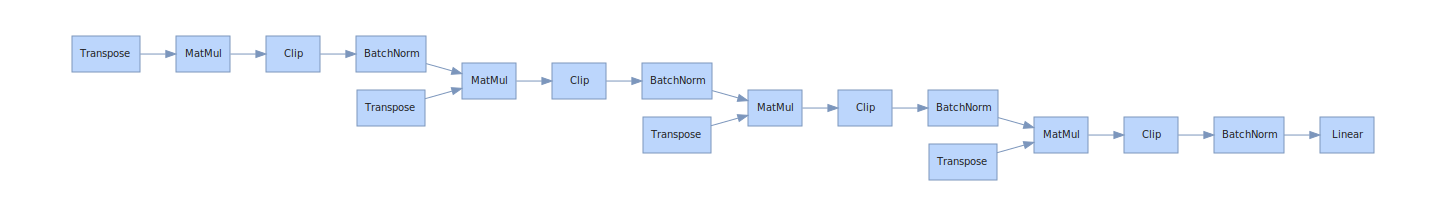

In [34]:
#conda install graphviz python-graphviz
#pip install hiddenlayer
import hiddenlayer as hl
hl_graph = hl.build_graph(model, torch.zeros(list(tuple([1, conv_input_size[0]])), device = device), )
hl_graph.theme = hl.graph.THEMES["blue"].copy()
hl_graph

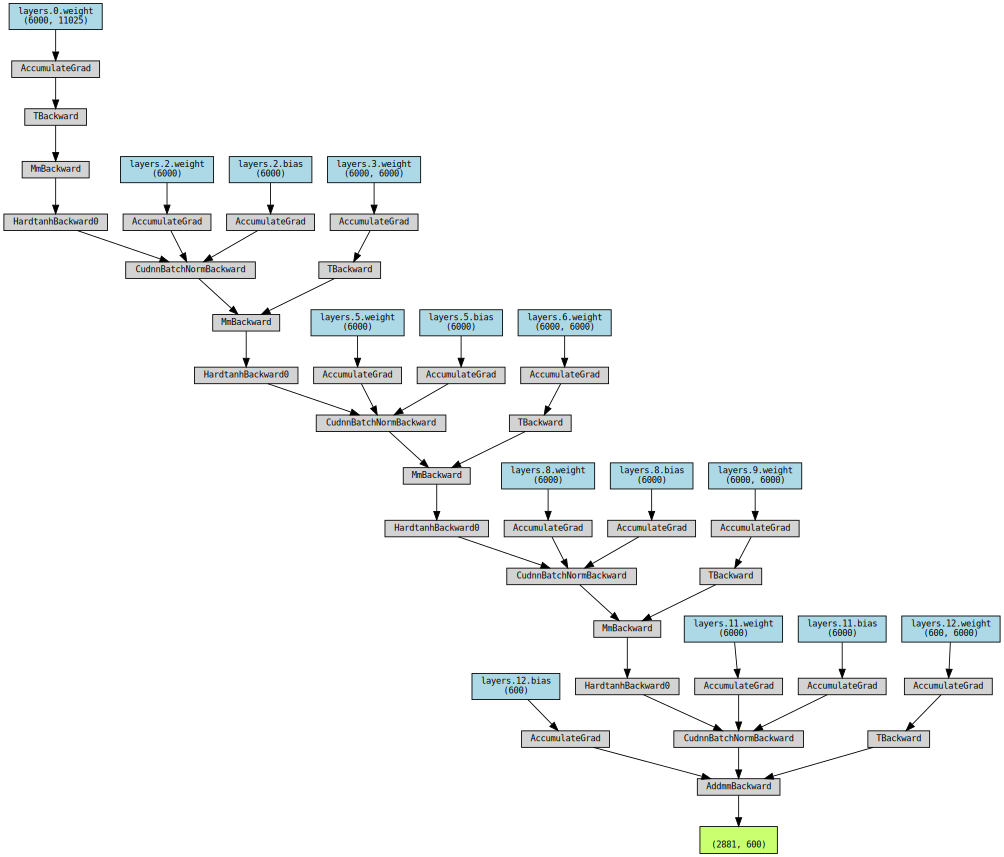

In [35]:
#pip install torchviz
from torchviz import make_dot
make_dot(model(torch.from_numpy(X_Test).to(device)), params = dict(list(model.named_parameters())), show_attrs = False, show_saved = False)#.render("NN", format = "png")